In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# biasutti2019riu

> Module that implements the model from [RIU-Net: Embarrassingly simple semantic segmentation of 3D LiDAR point cloud](https://arxiv.org/abs/1905.08748).

In [ ]:
#| default_exp biasutti2019riu

In [ ]:
#| export
import torch
import torch.nn.functional as F
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU, ModuleList, ConvTranspose2d
from torch.nn.init import kaiming_normal_, constant_, zeros_
from torch.nn.modules.module import register_module_forward_hook
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from lightning import LightningModule
from torchmetrics.classification import Accuracy
from collections import OrderedDict
import re
import wandb
import numpy as np

## RIUNet architecture

In [ ]:
#| export
class Block(Sequential):
    "Convolutional block repeatedly used in the RIU-Net encoder and decoder."
    def __init__(self, in_channels, out_channels):
        super().__init__(OrderedDict([
            (f'conv1', Conv2d(in_channels, out_channels, 3, 1, 1, bias=False, padding_mode='circular')),
            (f'bn1', BatchNorm2d(out_channels, momentum=0.01)),
            (f'relu1', ReLU()),
            (f'conv2', Conv2d(out_channels, out_channels, 3, 1, 1, bias=False, padding_mode='circular')),
            (f'bn2', BatchNorm2d(out_channels, momentum=0.01)),
            (f'relu2', ReLU()),
        ]))
        self.init_params()
    
    def init_params(self):
        for n, p in self.named_parameters():
            if re.search('conv\d\.weight', n):
                kaiming_normal_(p, nonlinearity='relu')
            if re.search('bn\d\.bias', n):
                constant_(p, 0.1)

It implements the following architecture:

```{mermaid}
flowchart LR
  A(("
  Input
  (bs, in_c, h, w)")) --> B["
  Conv(3x3)
  in_c -> out_c"]
  B --> C["BatchNorm2d"]
  C --> D["ReLU"]
  D --> E["
  Conv(3x3)
  out_c -> out_c"]
  E --> F["BatchNorm2d"]
  F --> G["ReLU"]
  G --> H(("
  Output
  (bs, out_c, h, w)"))
```

Here is an example on how to use it:

In [ ]:
bs, in_c, out_c, h, w = 1, 5, 64, 64, 512
inp = torch.randn(bs, in_c, h, w)

b = Block(in_c, out_c)
outp = b(inp)
assert outp.shape == (bs, out_c, h, w)
print(outp.shape, f'== ({bs}, {out_c}, {h}, {w})')

torch.Size([1, 64, 64, 512]) == (1, 64, 64, 512)


It initializes the weights from the conv layers following the [kaiming_normal_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_) algorithm in fan_in mode.

In [ ]:
#| eval: false
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

In [ ]:
#| eval: false
colors_list = list(mcolors.TABLEAU_COLORS)

def plot_param_dists(net, param_re_pattern, nonlinearity_gain):
    color_idx = 0
    for n, p in net.named_parameters():
        if re.search(param_re_pattern, n):
            x_range = 1.1*p.data.max()
            ## kaiming normal dist
            fan_in = p.shape[1]*p.shape[2]*p.shape[3]
            mu, sigma = 0., np.sqrt(nonlinearity_gain/fan_in)
            x = np.linspace(-x_range, x_range, 100)
            y = ((1./(np.sqrt(2*np.pi)*sigma))*np.exp(-0.5*((1./sigma)*(x - mu))**2))
            plt.plot(x, y, '--', color=colors_list[color_idx], label='Expected '+n)
            ## sampled weight dist
            plt.hist(p.view(-1).data, 30, density=True, alpha=0.5, color=colors_list[color_idx], label='Actual '+n)
            color_idx += 1
    plt.legend();

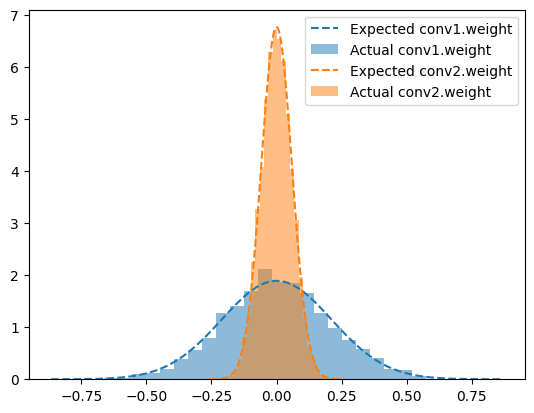

In [ ]:
#| eval: false
plot_param_dists(b, 'conv\d\.weight', 2.)

In [ ]:
for n, p in b.named_parameters():
    if re.search('conv\d\.weight', n):
        fan_in = p.shape[1]*p.shape[2]*p.shape[3]
        mu, sigma = 0., np.sqrt(2./fan_in)
        p_data = p.view(-1).data
        assert abs(mu - p_data.mean()) < 1e-2
        assert abs(sigma - p_data.std()) < 1e-2

It initializes the biases from the batch norm layers 0.1 above 0 to reduce the probability of dead neurons at the beginning of training.

In [ ]:
for n, p in b.named_parameters():
    if re.search('bn\d\.bias', n):
        assert (p.data == 0.1).all()

In [ ]:
#| export
class Encoder(Module):
    "RIU-Net encoder architecture."
    def __init__(self, channels=(5, 64, 128, 256, 512, 1024)):
        super().__init__()
        self.blocks = ModuleList(
            [Block(channels[i], channels[i+1]) for i in range(len(channels)-1)]
        )
    
    def forward(self, x):
        enc_features = []
        for block in self.blocks:
            x = block(x)
            enc_features.append(x)
            x = F.max_pool2d(x, 2)
        return enc_features

It implements the following architecture:

```{mermaid}
flowchart LR
  A(("
  Input
  (bs, 5, h, w)")) --> B["
  Block
  5 -> 64"]
  B --> C["MaxPool(2x2)"]
  C --> D["
  Block
  64 -> 128"]
  D --> E["MaxPool(2x2)"]
  E --> F["
  Block
  128 -> 256"]
  F --> G["MaxPool(2x2)"]
  G --> H["
  Block
  256 -> 512"]
  H --> I["MaxPool(2x2)"]
  I --> J["
  Block
  512 -> 1024"]
  B --> L(("
  Output
  [(bs, 64, h, w),
  (bs, 128, h/2, w/2),
  (bs, 256, h/4, w/4),
  (bs, 512, h/8, w/8),
  (bs, 1024, h/16, w/16)]"))
  D --> L
  F --> L
  H --> L
  J --> L
```

Here is an example on how to use it:

In [ ]:
enc = Encoder()
outp = enc(inp)
[o.shape for o in outp]

[torch.Size([1, 64, 64, 512]),
 torch.Size([1, 128, 32, 256]),
 torch.Size([1, 256, 16, 128]),
 torch.Size([1, 512, 8, 64]),
 torch.Size([1, 1024, 4, 32])]

In [ ]:
#| export
class Decoder(Module):
    "RIU-Net decoder architecture."
    def __init__(self, channels=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.upconvs = ModuleList(
            [ConvTranspose2d(channels[i], channels[i+1], 6, 2, 2, bias=False) for i in range(len(channels)-1)]
        )
        self.blocks = ModuleList(
            [Block(channels[i], channels[i+1]) for i in range(len(channels)-1)]
        )
        self.init_params()

    def init_params(self):
        for n, p in self.named_parameters():
            if re.search('upconvs\.\d\.weight', n):
                kaiming_normal_(p, nonlinearity='linear')
    
    def forward(self, enc_features):
        x = enc_features[-1]
        for i, (upconv, block) in enumerate(zip(self.upconvs, self.blocks)):
            x = upconv(x)
            x = torch.cat([x, enc_features[-(i+2)]], dim=1)
            x = block(x)
        return x

It implements the following architecture:

```{mermaid}
flowchart LR
  A(("
  Input
  [(bs, 1024, h/16, w/16),
  (bs, 512, h/8, w/8),
  (bs, 256, h/4, w/4),
  (bs, 128, h/2, w/2),
  (bs, 64, h, w)]")) --> B["
  ConvTranspose(2x2)
  1024 -> 512"]
  B --> C["
  Block
  concat(512,512) -> 512"]
  A --> C
  C --> D["
  ConvTranspose(2x2)
  512 -> 256"]
  D --> E["
  Block
  concat(256,256) -> 256"]
  A --> E
  E --> F["
  ConvTranspose(2x2)
  256 -> 128"]
  F --> G["
  Block
  concat(128,128) -> 128"]
  A --> G
  G --> H["
  ConvTranspose(2x2)
  128 -> 64"]
  H --> I["
  Block
  concat(64,64) -> 64"]
  A --> I
  I --> J(("
  Output
  (bs, 64, h, w)"))
```

Here is an example on how to use it:

In [ ]:
dec = Decoder()
fts = dec(outp)
assert fts.shape == (bs, out_c, h, w)
print(fts.shape, f'== ({bs}, {out_c}, {h}, {w})')

torch.Size([1, 64, 64, 512]) == (1, 64, 64, 512)


It initializes the weights from the upconv layers following the [kaiming_normal_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_) algorithm in fan_in mode and *nonlinearity* set as 'linear'.

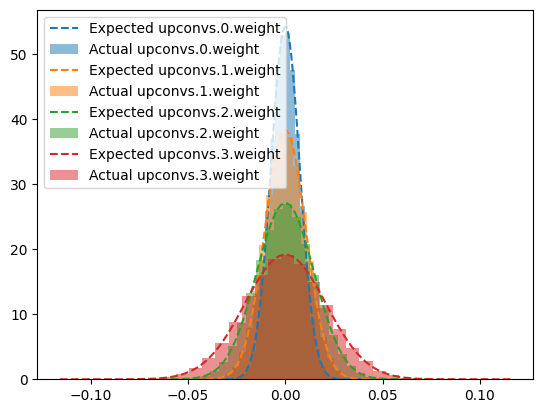

In [ ]:
#| eval: false
plot_param_dists(dec, 'upconvs\.\d\.weight', 1.)

In [ ]:
for n, p in dec.named_parameters():
    if re.search('upconvs\.\d\.weight', n):
        fan_in = p.shape[1]*p.shape[2]*p.shape[3]
        mu, sigma = 0., np.sqrt(1./fan_in)
        p_data = p.view(-1).data
        assert abs(mu - p_data.mean()) < 1e-3
        assert abs(sigma - p_data.std()) < 1e-3

In [ ]:
#| export
class RIUNet(Module):
    "RIU-Net complete architecture."
    def __init__(self, in_channels=5, hidden_channels=(64, 128, 256, 512, 1024), n_classes=20):
        super().__init__()
        self.n_classes = n_classes
        self.input_norm = BatchNorm2d(in_channels, affine=False, momentum=None)
        self.backbone = Sequential(OrderedDict([
            (f'enc', Encoder((in_channels, *hidden_channels))),
            (f'dec', Decoder(hidden_channels[::-1]))
        ]))
        self.head = Conv2d(hidden_channels[0], n_classes, 1)
        self.init_params()

    def init_params(self):
        for n, p in self.named_parameters():
            if re.search('head\.weight', n):
                kaiming_normal_(p, nonlinearity='linear')
            if re.search('head\.bias', n):
                zeros_(p)
    
    def forward(self, x):
        x = self.input_norm(x)
        features = self.backbone(x)
        prediction = self.head(features)
        
        return prediction

It implements the following architecture:

```{mermaid}
flowchart LR
  A(("
  Input
  (bs, 5, h, w)")) --> B["Encoder"]
  B --> C["Decoder"]
  C --> D["
  Conv(1x1)
  64 -> 20"]
  D --> E(("
  Output
  (bs, 20, h, w)"))
```

Here is an example on how to use it:

In [ ]:
n_classes=20
model = RIUNet()
logits = model(inp)
assert logits.shape == (bs, n_classes, h, w)
print(logits.shape, f'== ({bs}, {n_classes}, {h}, {w})')

torch.Size([1, 20, 64, 512]) == (1, 20, 64, 512)


It initializes the weights from the classification head following the [kaiming_normal_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_) algorithm in fan_in mode and *nonlinearity* set as 'linear'.

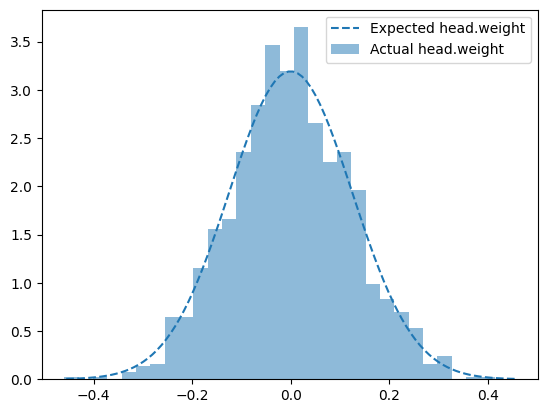

In [ ]:
#| eval: false
plot_param_dists(model, 'head\.weight', 1.)

In [ ]:
for n, p in model.named_parameters():
    if re.search('head\.weight', n):
        fan_in = p.shape[1]*p.shape[2]*p.shape[3]
        mu, sigma = 0., np.sqrt(1./fan_in)
        p_data = p.view(-1).data
        assert abs(mu - p_data.mean()) < 1e-2
        assert abs(sigma - p_data.std()) < 1e-2

## LightningModule for standard experiments

In [ ]:
#| export
def log_activations(logger, step, model, img):
    "Function that uses a Pytorch forward hook to log properties of activations for debugging purposes."
    def debugging_hook(module, inp, out):
        if 'relu' in module.name:
            acts = out.detach()
            min_count = (acts < 1e-1).sum((0, 2, 3))
            shape = acts.shape
            total_count = shape[0]*shape[2]*shape[3]
            rate = min_count/total_count
            logger.log({"max_dead_rate/" + str(module.name): rate.max()}, step=step)
    with register_module_forward_hook(debugging_hook):
        model(img)

In [ ]:
#| export
def log_imgs(pred, label, mask, viz_tfm, logger, stage, step):
    "TODO: documentation missing"
    pred_np = pred[0].detach().cpu().numpy().argmax(0)
    label_np = label[0].detach().cpu().numpy()
    mask_np = mask[0].detach().cpu().numpy()
    pred_np[pred_np == label_np] = 0
    _, pred_img, _ = viz_tfm(None, pred_np, mask_np)
    _, label_img, _ = viz_tfm(None, label_np, mask_np)
    img_cmp = np.concatenate((pred_img, label_img), axis=0)
    img_cmp = wandb.Image(img_cmp)
    logger.log({f"{stage}_examples": img_cmp}, step=step)

TODO: needs proper documentation with code examples for *log_activations* and *log_imgs* functions.

In [ ]:
#| export
class SemanticSegmentationTask(LightningModule):
    "Lightning Module to standardize experiments with semantic segmentation tasks."
    def __init__(self, model, loss_fn, viz_tfm, total_steps, lr=1e-3):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.viz_tfm = viz_tfm
        self.lr = lr
        self.total_steps = total_steps
        self.train_accuracy = Accuracy(task="multiclass", num_classes=model.n_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=model.n_classes)
        self.automatic_optimization = False

        self.step_idx = 0
        
        for n, m in self.model.named_modules():
            assert not hasattr(m, 'name')
            m.name = n
        
    def configure_optimizers(self):
        optimizer = Adam(self.model.parameters(), lr=self.lr, eps=1e-5)
        lr_scheduler = OneCycleLR(optimizer, self.lr, self.total_steps)
        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler}
    
    def training_step(self, batch, batch_idx):
        stage = 'train'
        logger = self.logger.experiment
        
        loss, pred, label, mask = self.step(batch, batch_idx, stage, self.train_accuracy)
        if self.step_idx % int(0.01*self.total_steps) == 0:
            log_activations(logger, self.step_idx, self.model, batch[0])
        if self.step_idx % int(0.25*self.total_steps) == 0:
            log_imgs(pred, label, mask, self.viz_tfm, logger, stage, self.step_idx)
        self.manual_optimization(loss)
        self.step_idx += 1
    
    def on_train_epoch_end(self):
        self.log('train_acc_epoch', self.train_accuracy)

    def validation_step(self, batch, batch_idx):
        stage = 'val'
        logger = self.logger.experiment
        
        _, pred, label, mask = self.step(batch, batch_idx, stage, self.val_accuracy)
        if batch_idx == 0:
            log_imgs(pred, label, mask, self.viz_tfm, logger, stage, self.step_idx)
    
    def step(self, batch, batch_idx, stage, metric):
        img, label, mask = batch
        label[~mask] = 0
        
        pred = self.model(img)
        
        loss = self.loss_fn(pred, label)
        loss = loss[mask]
        loss = loss.mean()

        pred_f = torch.permute(pred, (0, 2, 3, 1)) # N,C,H,W -> N,H,W,C
        pred_f = torch.flatten(pred_f, 0, -2)      # N,H,W,C -> N*H*W,C
        mask_f = torch.flatten(mask)               # N,H,W   -> N*H*W
        pred_m = pred_f[mask_f, :]
        label_m = label[mask]
        metric(pred_m, label_m)
        
        self.log(f"{stage}_acc_step", metric)
        self.log(f"{stage}_loss_step", loss)

        return loss, pred, label, mask
    
    def manual_optimization(self, loss):
        optimizer = self.optimizers()
        optimizer.zero_grad()
        self.manual_backward(loss)
        
        p_old = {}
        for n, p in self.model.named_parameters():
            p_old[n] = p.detach().clone()
        
        optimizer.step()
        
        for n, p in self.model.named_parameters():
            optim_step = p.detach() - p_old[n]
            self.logger.experiment.log({"ud/" + str(n): (optim_step.std()/(p_old[n].std() + 1e-5)).log10()}, step=self.step_idx)
        
        lr_scheduler = self.lr_schedulers()
        lr_scheduler.step()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()